In [90]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import keras
from tensorflow.python.framework import ops
from utils import *

In [91]:
data_path = r"Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\testData.mat"
mechFreq, optFreq, mechQ, optQ, paramsMat = load_data(data_path)

paramsShape = np.shape(paramsMat)[:-1]
num_examples = np.shape(paramsMat)[-1]
optQ_linearized = np.log(optQ)

paramsMat_transposed = tf.transpose(paramsMat, perm = [3, 0, 1, 2])
print("shape of paramsMat_transposed: \t", np.shape(paramsMat_transposed))

print("shape of optQ: \t", np.shape(optQ))

print("number of training examples: \t", num_examples)

Loading data from:  Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\testData.mat 

shape of paramsMat_transposed: 	 (911, 11, 18, 3)
shape of optQ: 	 (911, 1)
number of training examples: 	 911


Split the data into train and test sets using tensorflow. Because optical Q is generally sampled logrithmically, to train with a linear activation in the last layer we should take the log of the optical Q data before giving it to the model.

In [92]:
dataset = tf.data.Dataset.from_tensor_slices((paramsMat_transposed, optQ_linearized))

# Shuffle and split the dataset
train_size = int(0.8 * num_examples)
train_dataset = dataset.shuffle(buffer_size=num_examples).take(train_size)
test_dataset = dataset.skip(train_size)

# Example of batching the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Define the model

In [93]:
# define the model using the functional API structure rather than teh sequential structure in order to make it more flexible in the future.

def CNN_model(input_shape, kernel_size = [6, 2], pool_size = [8, 4], FC_nodes = [10]):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE

    Arguments:
    input_img -- input dataset, of shape (input_shape)
    kernel_size -- list of kernel sizes for each Conv2D step
    pool_size -- list of pool sizes for each MaxPool2D step

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)

    Z1 = tfl.Conv2D(filters = 8, kernel_size = (kernel_size[0], kernel_size[0]), strides = 1, padding = 'same')(input_img)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size = (pool_size[0], pool_size[0]), strides = 2, padding = 'same')(A1)
    
    Z2 = tfl.Conv2D(filters = 16, kernel_size = (kernel_size[1], kernel_size[1]), strides = 1, padding = 'same')(P1)
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D(pool_size = (pool_size[1], pool_size[1]), strides = 1, padding = 'same')(A2)
    
    F = tfl.Flatten()(P2)

    A3 = tfl.Dense(FC_nodes[0], activation = 'relu')(F)

    output = tfl.Dense(1)(A3)
    
    model = tf.keras.Model(inputs=input_img, outputs=output)
    return model

In [94]:
conv_model = CNN_model(paramsShape)
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
conv_model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics =['mse'])

conv_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 11, 18, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 11, 18, 8)           │             872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_30 (ReLU)                      │ (None, 11, 18, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 6, 9, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 6, 9, 16)            │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_31 (ReLU)                      │ (None, 6, 9, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 6, 9, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 864)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │           8,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,061 (39.30 KB)

 Trainable params: 10,061 (39.30 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 27.8792 - mse: 27.8792 - val_loss: 2.1449 - val_mse: 2.1449
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7996 - mse: 1.7996 - val_loss: 1.0429 - val_mse: 1.0429
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0881 - mse: 1.0881 - val_loss: 0.9598 - val_mse: 0.9598
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1950 - mse: 1.1950 - val_loss: 1.2035 - val_mse: 1.2035
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1249 - mse: 1.1249 - val_loss: 1.0389 - val_mse: 1.0389
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1777 - mse: 1.1777 - val_loss: 1.0427 - val_mse: 1.0427
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9418 - mse: 0.9418 - val_loss: 1.1704 - val_mse: 1.1704
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9941 - mse: 0.9941 - val_loss: 0.9707 - val_mse: 0.9707
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0

In [67]:
conv_model.evaluate(test_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4368 - mse: 0.4368


[0.40938955545425415, 0.40938955545425415]

Index(['loss', 'mse', 'val_loss', 'val_mse'], dtype='object')


C:\Users\Linus\AppData\Local\Temp\ipykernel_33724\747123822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\Linus\AppData\Local\Temp\ipykernel_33724\747123822.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

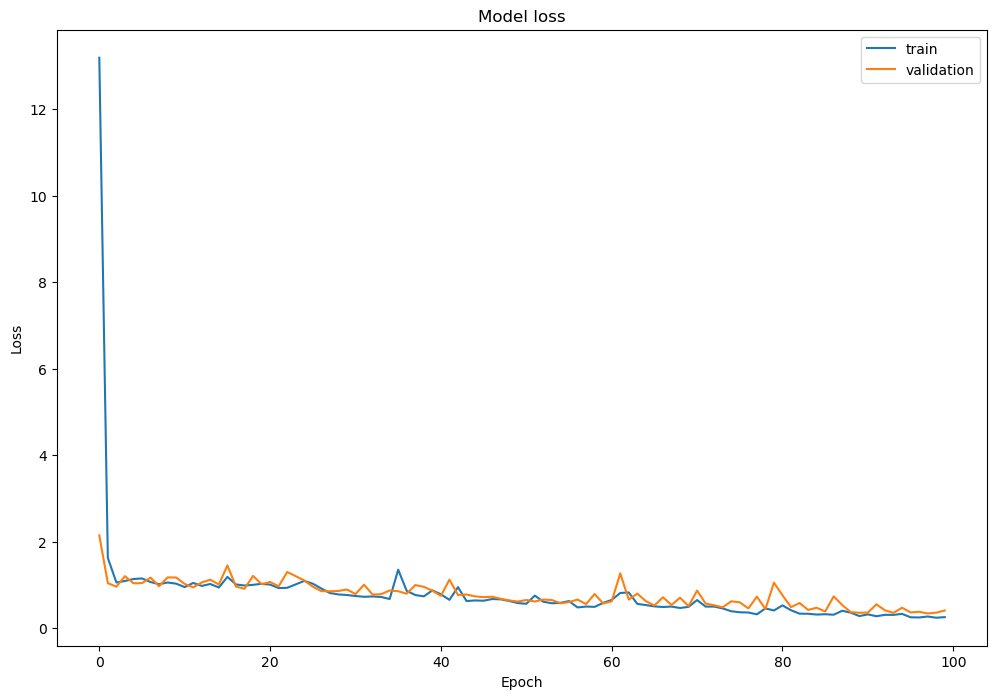

In [68]:
df_loss_acc = pd.DataFrame(history.history)
print(df_loss_acc.columns)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_mse= df_loss_acc[['mse','val_mse']]
df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)

df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
# df_mse.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='MSE')

With a trained model in hand it might be nice to see individual examples of how good it is at predicting...

In [69]:
train_numbers = np.arange(10)
for train_number in train_numbers:
    test_iterator = iter(test_dataset)
    
    # Get a single batch (you can also use next(test_iterator) for just one item in the batch)
    batch_X, batch_Y = next(test_iterator)
    
    # Extract a single input and label pair from the batch
    # For example, take the first item from the batch
    single_input = batch_X[train_number].numpy()  # Convert to NumPy array
    single_label = batch_Y[train_number].numpy()  # Convert to NumPy array
    
    single_input =  np.expand_dims(single_input, axis=0) 
    
    prediction = conv_model.predict(single_input)
    
    print("predicted Q = {}".format(np.exp(prediction)))
    print("true Q = {}".format(np.exp(single_label)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
predicted Q = [[2113.62]]
true Q = [1764.473252]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[6315.2036]]
true Q = [10275.52294081]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[1875.7639]]
true Q = [3040.12035094]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[4212.159]]
true Q = [12165.39992799]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
predicted Q = [[520.87714]]
true Q = [900.82855068]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[8942.716]]
true Q = [8187.85774313]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[12601.296]]
true Q = [24255.90580533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[26304.266]]
true Q = [10110.06770586]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[12526.242]]
true Q = [17853.10393943]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[4684.145]]
true Q = [5647.03080601]


Seems like the model is having a hard time with large Q modes and low Q modes.  Need to think about good ways to give these outliers appropriate weight. ie. model is high bias currently.  however, gets the MSE down below 1 so we are consistently within an order of magnitude ~ this is sort of good.

## parametrizing the model for a random hyperparam search

In [174]:
def hyper_param_search(kernel_sizes, filters, pool_sizes, FC_nodes, lr):
    """
    takes hyperparameters as input, then initializes and trains a model.
    _____________________________________________________________________
    Inputs:
        kernel_sizes - the kernel sizes for each convolutional layer
        filters - the number of filters used for each convolutional layer
        pool_size - the pool size for max pool operations between convolutions
        FC_node - the number of nodes in each dense layer of the model
        lr - the learning rate for the adam optimizer
    Outputs:
        performance - the performance of the trained model on the dev dataset
    """

    def CNN_model(input_shape, kernel_sizes = [6, 2], filters = [8, 16], pool_sizes = [8, 4], FC_nodes = [10]):
        """
        Implements the forward propagation for the model:
        CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
        Arguments:
        input_img -- input dataset, of shape (input_shape)
        kernel_size -- list of kernel sizes for each Conv2D step
        pool_size -- list of pool sizes for each MaxPool2D step
    
        Returns:
        model -- TF Keras model (object containing the information for the entire training process) 
        """
    
        input_img = tf.keras.Input(shape=input_shape)
    
        P = input_img
        
        for kernel_size, num_filters, pool_size in zip(kernel_sizes, filters, pool_sizes):
            Z = tfl.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size), strides = 1, padding = 'same')(P)
            A = tfl.ReLU()(Z)
            P = tfl.MaxPool2D(pool_size = (pool_size, pool_size), strides = 2, padding = 'same')(A)
        
        F = tfl.Flatten()(P)
        A = F

        for node in FC_nodes:
            A = tfl.Dense(node, activation = 'relu')(F)
    
        output = tfl.Dense(1)(A)
        
        model = tf.keras.Model(inputs=input_img, outputs=output)
        return model
    
    conv_model = CNN_model(paramsShape)
    optimizer = keras.optimizers.Adam(learning_rate = lr)
    conv_model.compile(optimizer=optimizer,
                      loss='mse',
                      metrics =['mse'])

    history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)
    performance = conv_model.evaluate(test_dataset)
    return performance

In [179]:
def gen_random_hyperparams():
    '''
    generates hyperparameters to feed to the parameterized CNN model
        randomly chooses a number of convolutional + maxpool blocks between 1 and 6
        randomly selects set of conv kernel sizes, max pool sizes, and conv filter numbers
        randomly chooses number of dense layers between 1 and 4
        randomly chooses number of nodes in each dense layer
        randomly selects a learning rate on a log scale in the range 1e-1 to 1e-5

    The parameters are sorted such that the model gets increasingly more channels, the mask for conv and maxpool shrinks
    and the fully connected layers go to fewer and fewer nodes moving from input to output of the model.
    '''
    # number of conv + pool layers there will be, between 1 and 6
    num_conv_itters = np.random.randint(1, 6)

    # create list of random integers for the kernel sizes, pool sizes, and num_filers.  The filter numbers should increase
    # while the kernel sizes and pool sizes should decrease.
    kernel_sizes = [np.random.randint(1, 11) for _ in range(num_conv_itters)] # 11 is natural upper bound as this is the dimension of the input on one axis
    kernel_sizes = sorted(kernel_sizes, reverse=True)

    pool_sizes = [np.random.randint(1, 11) for _ in range(num_conv_itters)] # 11 is natural upper bound as this is the dimension of the input on one axis
    pool_sizes = sorted(pool_sizes, reverse=True)

    filters = [np.random.randint(1, 25) for _ in range(num_conv_itters)] # the filters should be sorted starting with fewer filters and going to more
    filters = sorted(filters, reverse=False)

    num_dense_itters = np.random.randint(1, 4)
    FC_nodes = [2**np.random.randint(1, 8) for _ in range(num_dense_itters)] # 11 is natural upper bound as this is the dimension of the input on one axis
    pool_sizes = sorted(pool_sizes, reverse=True)

    # randomly generate the learning rate on a log scale
    rng = 4 # range of exponents
    center = 3 # center of distribution
    lr = 10**-(np.random.rand()*rng + (center-rng/2))

    return kernel_sizes, filters, pool_sizes, FC_nodes, lr



# check that this works once.
performance = hyper_param_search(*gen_random_hyperparams())
print(performance)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 82.7153 - mse: 82.7153 - val_loss: 78.8677 - val_mse: 78.8677
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80.1872 - mse: 80.1872 - val_loss: 76.5347 - val_mse: 76.5347
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77.7400 - mse: 77.7400 - val_loss: 74.1294 - val_mse: 74.1294
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75.9314 - mse: 75.9314 - val_loss: 71.1896 - val_mse: 71.1896
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71.8966 - mse: 71.8966 - val_loss: 67.5097 - val_mse: 67.5097
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67.9913 - mse: 67.9913 - val_loss: 62.9566 - val_mse: 62.9566
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63.9021 - mse: 63.9021 - val_loss: 57.4999 - val_mse: 57.4999
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.9465 - mse: 56.9465 - val_loss: 51.1610 - val_mse: 51.1610
Epoch 9/100
23/23 ━━━━━━━━━━━━━━